# Last Chapter Bachelor Arbeit with Play by play data 

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime

import math 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib

from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

plt.style.use('fivethirtyeight')

# colors 
gold ='#D3BC8D'
black = '#101820'
grey = '#707070'

In [2]:
#Play by play dataset from https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016
data = pd.read_csv('data/NFL_Play_by_Play_2009-2018_v5.csv')

/Users/felixbok/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.describe()

,play_id,game_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,...,assist_tackle_4_team,fumble_recovery_1_yards,fumble_recovery_2_yards,return_yards,penalty_yards,replay_or_challenge,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
count,449371.000000,4.493710e+05,436301.000000,449230.000000,449206.000000,449208.000000,449371.000000,449371.000000,449371.000000,449371.000000,...,0.0,6026.000000,47.000000,449350.000000,32618.000000,449371.000000,436497.000000,436497.000000,436497.0,436497.0
mean,2140.689606,2.013620e+09,49.800658,413.968820,810.775709,1700.697033,0.017111,12.275053,0.072090,2.577696,...,NaN,2.302688,4.808511,1.042773,8.487829,0.001823,0.000069,0.000014,0.0,0.0
std,1240.303671,2.842246e+06,25.062131,279.137304,554.712205,1053.533368,0.129684,7.124626,0.258637,1.129958,...,NaN,9.066064,14.961746,5.462253,5.323953,0.042652,0.008290,0.003708,0.0,0.0
min,35.000000,2.009091e+09,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,NaN,-34.000000,-16.000000,-18.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,1074.000000,2.011111e+09,31.000000,152.000000,286.000000,784.000000,0.000000,6.000000,0.000000,2.000000,...,NaN,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,2125.000000,2.013123e+09,52.000000,396.000000,797.000000,1800.000000,0.000000,12.000000,0.000000,3.000000,...,NaN,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,3180.000000,2.016103e+09,71.000000,656.000000,1288.000000,2583.000000,0.000000,18.000000,0.000000,4.000000,...,NaN,0.000000,4.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.0,0.0
max,5706.000000,2.018122e+09,99.000000,900.000000,1800.000000,3600.000000,1.000000,38.000000,1.000000,5.000000,...,NaN,93.000000,77.000000,109.000000,66.000000,1.000000,1.000000,1.000000,0.0,0.0


In [4]:
df = data[['game_id','game_date','home_team', 'away_team','posteam','posteam_type','side_of_field','yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining','game_seconds_remaining', 'game_half','down','qtr', 'yrdln','ydstogo','ydsnet','play_type','yards_gained', 'shotgun', 'no_huddle','qb_dropback', 'qb_scramble', 'pass_location','posteam_timeouts_remaining', 'complete_pass', 'score_differential']]
df = df.loc[(df['play_type'] == 'pass')]
df = df.loc[(df['posteam'] == 'NO')]

df = df.dropna()
df = df.reset_index()
df = df.drop(axis = 1, columns = ['index', 'home_team', 'posteam_type','game_half','away_team', 'posteam', 'side_of_field', 'yrdln','play_type', 'qb_dropback','qb_scramble'])
df = pd.get_dummies(df, columns = ['pass_location'])
df['complete_pass'] = df['complete_pass'].apply(lambda x: int(x))
df['yardline_100'] = df['yardline_100'].apply(lambda x: int(x))
df['quarter_seconds_remaining'] = df['quarter_seconds_remaining'].apply(lambda x: int(x))
df['half_seconds_remaining'] = df['half_seconds_remaining'].apply(lambda x: int(x))
df['game_seconds_remaining'] = df['game_seconds_remaining'].apply(lambda x: int(x))
df['down'] = df['down'].apply(lambda x: int(x))
df['yards_gained'] = df['yards_gained'].apply(lambda x: int(x))
df['posteam_timeouts_remaining'] = df['posteam_timeouts_remaining'].apply(lambda x: int(x))
df['score_differential'] = df['score_differential'].apply(lambda x: int(x))
df['game_date'] = df['game_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

def toseason(x):
    if x < datetime(2010, 5, 1):
        return 2009
    if x < datetime(2011, 5,1):
        return 2010
    if x < datetime(2012, 5,1):
        return 2011
    if x < datetime(2013, 5,1):
        return 2012
    if x < datetime(2014,5,1):
        return 2013
    if x < datetime(2015,5,1):
        return 2014
    if x < datetime(2016,5,1):
        return 2015
    if x < datetime(2017,5,1):
        return 2016 
    if x < datetime(2018,5,1):
        return 2017
    if x < datetime(2019,5,1):
        return 2018

df['season'] = df['game_date'].apply(lambda x: toseason(x))
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Data columns (total 20 columns):
game_id                       6144 non-null int64
game_date                     6144 non-null datetime64[ns]
yardline_100                  6144 non-null int64
quarter_seconds_remaining     6144 non-null int64
half_seconds_remaining        6144 non-null int64
game_seconds_remaining        6144 non-null int64
down                          6144 non-null int64
qtr                           6144 non-null int64
ydstogo                       6144 non-null int64
ydsnet                        6144 non-null int64
yards_gained                  6144 non-null int64
shotgun                       6144 non-null int64
no_huddle                     6144 non-null int64
posteam_timeouts_remaining    6144 non-null int64
complete_pass                 6144 non-null int64
score_differential            6144 non-null int64
pass_location_left            6144 non-null uint8
pass_location_middle          6144

,game_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,down,qtr,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,posteam_timeouts_remaining,complete_pass,score_differential,pass_location_left,pass_location_middle,pass_location_right,season
count,6.144000e+03,6144.000000,6144.000000,6144.000000,6144.00000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000
mean,2.013521e+09,51.668783,425.453125,821.253906,1748.50000,1.884277,2.537109,8.693034,34.093099,7.948405,0.661784,0.034993,2.429036,0.701335,-1.019206,0.383789,0.217122,0.399089,2013.384928
std,2.754716e+06,24.800999,272.904980,545.730806,1031.25858,0.821999,1.123755,3.878655,25.887436,10.124157,0.473141,0.183778,0.854083,0.457710,10.368372,0.486347,0.412320,0.489751,2.758812
min,2.009091e+09,1.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,-16.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,-38.000000,0.000000,0.000000,0.000000,2009.000000
25%,2.011111e+09,32.000000,176.000000,310.000000,855.75000,1.000000,2.000000,6.000000,12.000000,0.000000,0.000000,0.000000,2.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,2011.000000
50%,2.013122e+09,55.000000,404.000000,807.000000,1826.50000,2.000000,2.000000,10.000000,29.000000,6.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2013.000000
75%,2.016100e+09,73.000000,669.000000,1279.000000,2606.00000,3.000000,4.000000,10.000000,55.000000,12.000000,1.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.000000,1.000000,2016.000000
max,2.018122e+09,99.000000,900.000000,1800.000000,3600.00000,4.000000,5.000000,38.000000,98.000000,98.000000,1.000000,1.000000,3.000000,1.000000,41.000000,1.000000,1.000000,1.000000,2018.000000


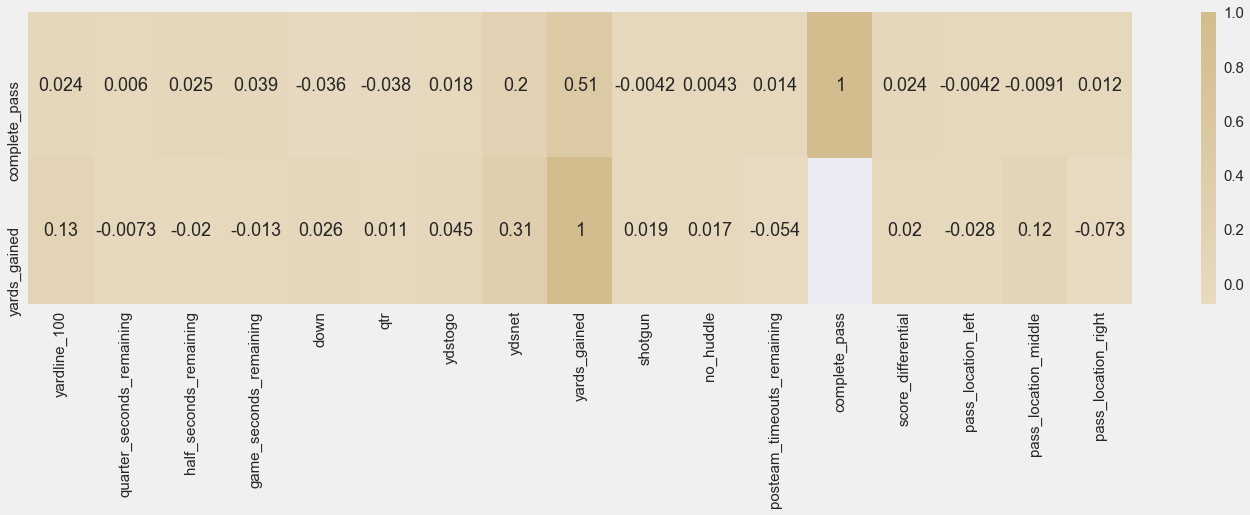

In [31]:
x3 = 25 
df4 = df.drop(axis = 1, columns = ['game_id', 'season'])
corr1 = df4.corr().loc[['complete_pass']]

df_complete_pass = df.drop(df[df.complete_pass == 0].index).drop(axis = 1, columns = ['game_id', 'season'])
corr2 = df_complete_pass = df_complete_pass.corr().loc[['yards_gained']]
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask, k = 0)] = True

corr = pd.concat([corr1, corr2])
#grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
#f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize = (20,5))
plt.figure(figsize = (20,7.5))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
sns.heatmap(corr, annot = True, cmap=sns.light_palette(gold, as_cmap=True), center = 0, )
plt.tight_layout()
plt.savefig('figures/heatmap_play-to-play.png',bbox_inches = 'tight')
#corr

###### df4.info()

In [6]:
#To do: train-test-split! 
df_train = pd.DataFrame(columns = df.columns)
df_test = pd.DataFrame(columns = df.columns)
season = 2009
traingames = 11
game_id = 0 

for i in range(2009,2020):
    count = 0
    for index, row in df.iterrows():
        if row.season == i:
            if count <= traingames:
                df_train.loc[index] = row
            else:
                df_test.loc[index] = row
                
            if game_id != row.game_id:
                count += 1
                game_id = row.game_id
                
df_train = df_train.drop(axis = 1, columns = ['game_id', 'game_date','season'])
df_test = df_test.drop(axis = 1, columns = ['game_id', 'game_date','season'])

df_train.to_csv('seminar_nfl/play-by-play_processed_train.csv')
df_test.to_csv('seminar_nfl/play-by-play_processed_test.csv')

In [7]:
incomplete = df_train[df_train['complete_pass'] == 0]
complete = df_train[df_train['complete_pass'] == 1]

complete.info()

count = 1251 # count of incomplete passes 

complete = complete.iloc[::2].iloc[:count]

df_train1 = pd.concat([complete,incomplete])

df_train1.to_csv('seminar_nfl/df_train1.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2970 entries, 0 to 6048
Data columns (total 17 columns):
yardline_100                  2970 non-null object
quarter_seconds_remaining     2970 non-null object
half_seconds_remaining        2970 non-null object
game_seconds_remaining        2970 non-null object
down                          2970 non-null object
qtr                           2970 non-null object
ydstogo                       2970 non-null object
ydsnet                        2970 non-null object
yards_gained                  2970 non-null object
shotgun                       2970 non-null object
no_huddle                     2970 non-null object
posteam_timeouts_remaining    2970 non-null object
complete_pass                 2970 non-null object
score_differential            2970 non-null object
pass_location_left            2970 non-null object
pass_location_middle          2970 non-null object
pass_location_right           2970 non-null object
dtypes: object(17)
memory 

In [8]:
df_test[['yardline_100', 'down', 'ydsnet', 'posteam_timeouts_remaining', 'score_differential', 'complete_pass']].to_csv('seminar_nfl/play-by-play_processed_test_half.csv')
df_train1[['yardline_100', 'down', 'ydsnet', 'posteam_timeouts_remaining', 'score_differential', 'complete_pass']].to_csv('seminar_nfl/play-by-play_processed_train_half.csv')

In [9]:
df_complete_pass = df.drop(df[df.complete_pass == 0].index)

df_complete_pass = df_complete_pass.drop(axis = 1, columns = ['complete_pass'])
df_complete_pass.to_csv('seminar_nfl/play-by-play_processed_complete_pass.csv')
df_complete_pass.info()
df_complete_pass.head()

df_complete_pass.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4309 entries, 0 to 6143
Data columns (total 19 columns):
game_id                       4309 non-null int64
game_date                     4309 non-null datetime64[ns]
yardline_100                  4309 non-null int64
quarter_seconds_remaining     4309 non-null int64
half_seconds_remaining        4309 non-null int64
game_seconds_remaining        4309 non-null int64
down                          4309 non-null int64
qtr                           4309 non-null int64
ydstogo                       4309 non-null int64
ydsnet                        4309 non-null int64
yards_gained                  4309 non-null int64
shotgun                       4309 non-null int64
no_huddle                     4309 non-null int64
posteam_timeouts_remaining    4309 non-null int64
score_differential            4309 non-null int64
pass_location_left            4309 non-null uint8
pass_location_middle          4309 non-null uint8
pass_location_right           4309

,game_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,down,qtr,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,posteam_timeouts_remaining,score_differential,pass_location_left,pass_location_middle,pass_location_right,season
count,4.309000e+03,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000
mean,2.013566e+09,52.063356,426.530285,830.057786,1774.546066,1.864934,2.509399,8.739615,37.469947,11.333256,0.660478,0.035507,2.436760,-0.859596,0.382455,0.214667,0.402878,2013.431655
std,2.781125e+06,24.319750,273.598889,543.624914,1031.227697,0.809558,1.122579,3.874237,25.392323,10.382086,0.473602,0.185079,0.852657,10.225204,0.486043,0.410639,0.490533,2.784888
min,2.009091e+09,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,-12.000000,-10.000000,0.000000,0.000000,0.000000,-38.000000,0.000000,0.000000,0.000000,2009.000000
25%,2.011111e+09,33.000000,176.000000,322.000000,900.000000,1.000000,2.000000,6.000000,15.000000,5.000000,0.000000,0.000000,2.000000,-7.000000,0.000000,0.000000,0.000000,2011.000000
50%,2.013122e+09,56.000000,404.000000,822.000000,1839.000000,2.000000,2.000000,10.000000,33.000000,9.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2013.000000
75%,2.016102e+09,73.000000,669.000000,1282.000000,2643.000000,2.000000,4.000000,10.000000,59.000000,15.000000,1.000000,0.000000,3.000000,6.000000,1.000000,0.000000,1.000000,2016.000000
max,2.018122e+09,99.000000,900.000000,1800.000000,3600.000000,4.000000,5.000000,38.000000,98.000000,98.000000,1.000000,1.000000,3.000000,38.000000,1.000000,1.000000,1.000000,2018.000000


In [10]:
df_complete_pass_transformed = pd.DataFrame()
df_complete_pass_transformed = df_complete_pass
df_complete_pass_transformed['yards_gained'] = df_complete_pass_transformed['yards_gained'].apply(lambda x: math.log(x+11))
df_complete_pass_transformed.to_csv('seminar_nfl/play-by-play_processed_complete_pass_transformed.csv')
df_complete_pass_transformed['yards_gained'].describe()

df_complete_pass = df.drop(df[df.complete_pass == 0].index)
df_complete_pass = df_complete_pass.drop(axis = 1, columns = ['complete_pass'])

/Users/felixbok/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/felixbok/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


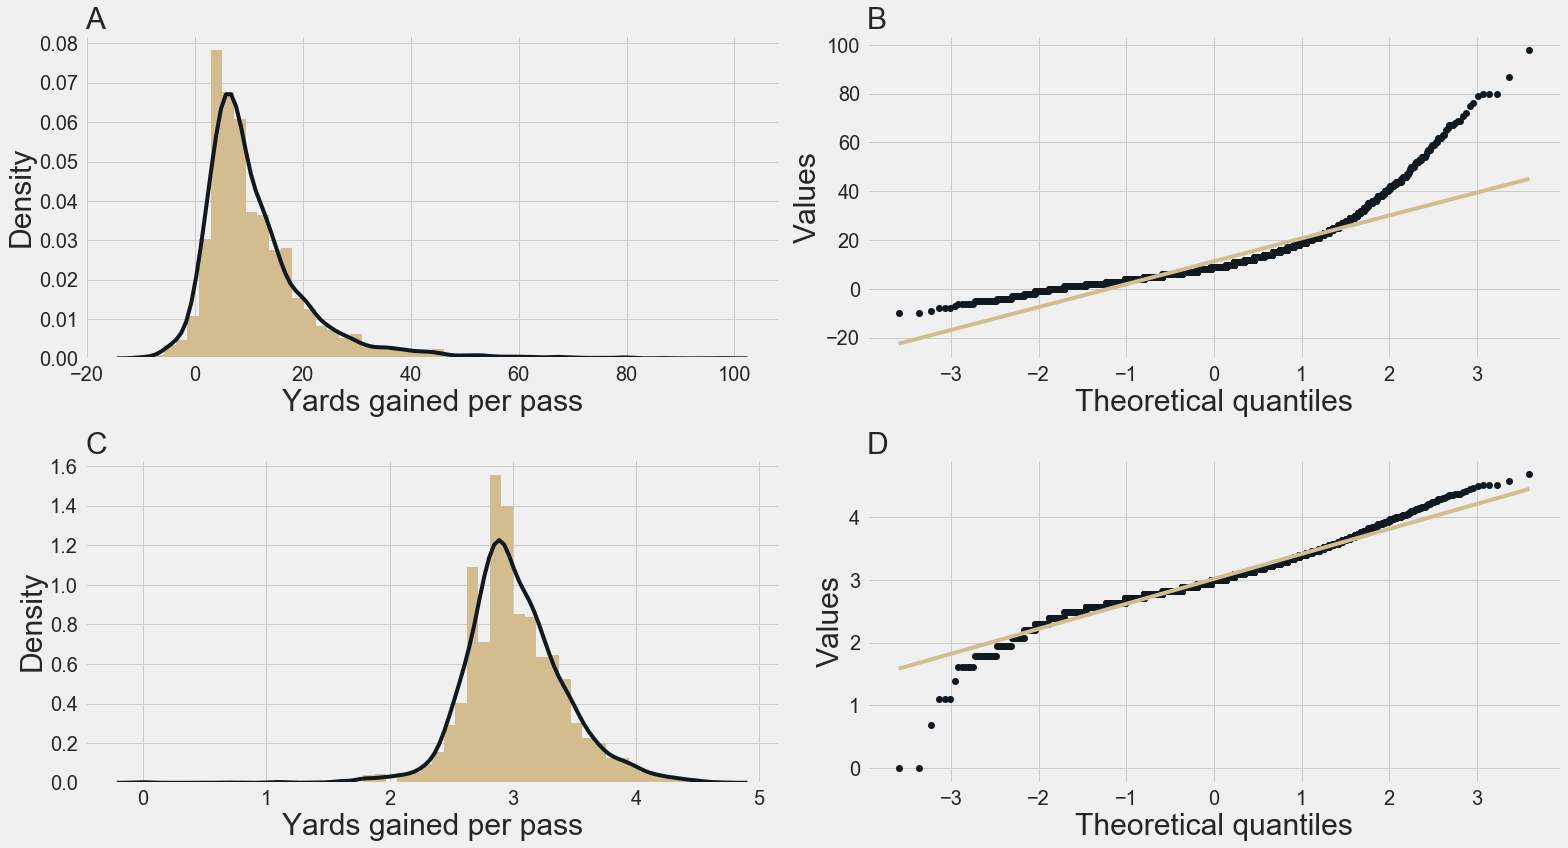

In [30]:

x2 = 30 # fontsize label 
x3 = 20 # fontsize ticks 
x4 = 30 #fontsize title 

plt.figure(figsize = (22,12))
plt.subplot(2,2,1)
plt.style.use('fivethirtyeight')
plt.title('A', fontsize = x4, loc = 'left')
x = df_complete_pass['yards_gained']
sns.distplot(x, hist_kws={"alpha": 1, "color": gold}, kde_kws={"color": black})
plt.ylabel('Density', fontsize = x2)
plt.xlabel('Yards gained per pass', fontsize = x2)
plt.xticks(fontsize = x3) 
plt.yticks(fontsize = x3)

ax = plt.subplot(2,2,2)
plt.style.use('fivethirtyeight')
stats.probplot(x, plot = plt)
ax.get_lines()[0].set_color(black)
ax.get_lines()[1].set_color(gold)
plt.xlabel('Theoretical quantiles',fontsize = x2)
plt.ylabel('Values',fontsize = x2)
plt.xticks(fontsize = x3) 
plt.yticks(fontsize = x3)
plt.title('B', fontsize = x4, loc = 'left')
plt.title('')


plt.subplot(2,2,3)
plt.title('C', fontsize = x4, loc = 'left')
x = df_complete_pass_transformed['yards_gained']
sns.distplot(x, hist_kws={"alpha": 1, "color": gold}, kde_kws={"color": black})
plt.ylabel('Density', fontsize = x2)
plt.xlabel('Yards gained per pass', fontsize = x2)
plt.xticks(fontsize = x3) 
plt.yticks(fontsize = x3)

ax = plt.subplot(2,2,4)
stats.probplot(x, plot = plt)
ax.get_lines()[0].set_color(black)
ax.get_lines()[1].set_color(gold)
plt.xlabel('Theoretical quantiles',fontsize = x2)
plt.ylabel('Values',fontsize = x2)
plt.xticks(fontsize = x3) 
plt.yticks(fontsize = x3)
plt.title('D', fontsize = x4, loc = 'left')
plt.title('')

plt.tight_layout()
plt.savefig('figures/distplot_yards_gained_pass.png')
plt.show()


In [12]:
df_complete_pass['yards_gained'].describe()

count    4309.000000
mean       11.333256
std        10.382086
min       -10.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        98.000000
Name: yards_gained, dtype: float64

/Users/felixbok/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


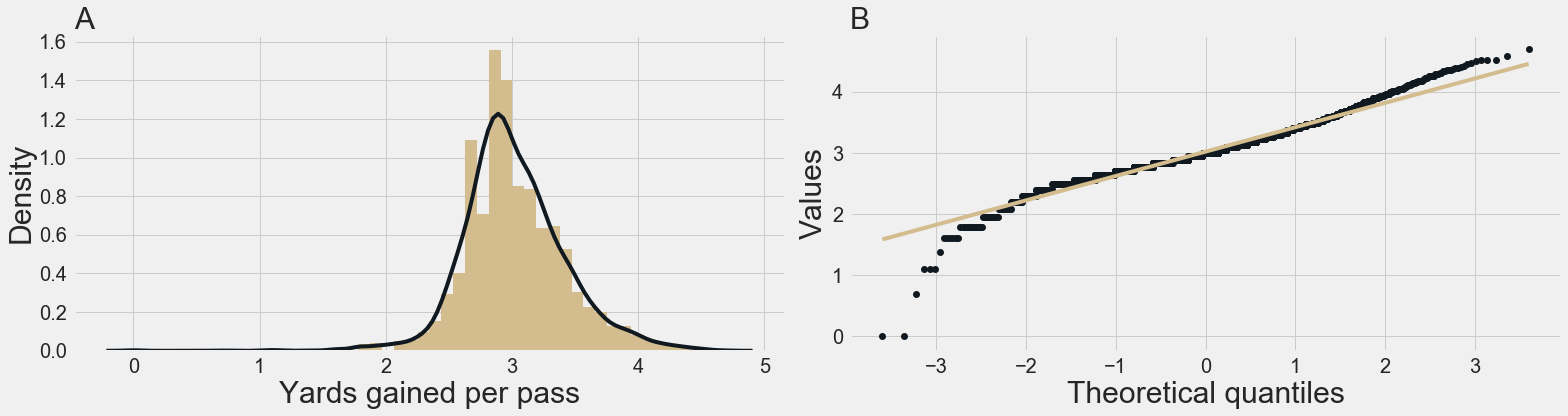

In [29]:
x2 = 30 # fontsize label 
x3 = 20 # fontsize ticks 
x4 = 30 #fontsize title 

plt.figure(figsize = (22,6))
plt.subplot(1,2,1)
plt.style.use('fivethirtyeight')
plt.title('A', fontsize = x4, loc = 'left')
x = df_complete_pass_transformed['yards_gained']
sns.distplot(x, hist_kws={"alpha": 1, "color": gold}, kde_kws={"color": black})
plt.ylabel('Density', fontsize = x2)
plt.xlabel('Yards gained per pass', fontsize = x2)
plt.xticks(fontsize = x3) 
plt.yticks(fontsize = x3)

ax = plt.subplot(1,2,2)
plt.style.use('fivethirtyeight')
stats.probplot(x, plot = plt)
ax.get_lines()[0].set_color(black)
ax.get_lines()[1].set_color(gold)
plt.xlabel('Theoretical quantiles',fontsize = x2)
plt.ylabel('Values',fontsize = x2)
plt.xticks(fontsize = x3) 
plt.yticks(fontsize = x3)
plt.title('B', fontsize = x4, loc = 'left')
plt.title('')

plt.tight_layout()
plt.savefig('figures/distplot_yards_gained_pass_completed_transformed.png')
plt.show()

In [14]:
x1 = pd.read_csv('seminar_nfl/final_logistic_rec_coefficients_BIC.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/final_logistic_rec_coefficients_BIC.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r|r', bold_rows = True))
  
x1 = pd.read_csv('seminar_nfl/odds_final_logistic_rec_BIC.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/odds_final_logistic_rec_BIC.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r', bold_rows = True))
    
x1 = pd.read_csv('seminar_nfl/final_logistic_rec_coefficients_AIC.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/final_logistic_rec_coefficients_AIC.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r|r', bold_rows = True))  

x1 = pd.read_csv('seminar_nfl/odds_final_logistic_rec_AIC.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/odds_final_logistic_rec_AIC.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r', bold_rows = True)) 
    
x1 = pd.read_csv('seminar_nfl/final_multiple_rec_coefficients_BIC.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/final_multiple_rec_coefficients_BIC.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r|r', bold_rows = True)) 

x1 = pd.read_csv('seminar_nfl/final_multiple_rec_coefficients_AIC.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/final_multiple_rec_coefficients_AIC.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r|r', bold_rows = True)) 
    
x1 = pd.read_csv('seminar_nfl/final_multiple_rec_coefficients_BIC_transformed.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/final_multiple_rec_coefficients_BIC_transformed.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r|r', bold_rows = True)) 

x1 = pd.read_csv('seminar_nfl/final_logistic_rec_coefficients_BIC_subsampled.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/final_logistic_rec_coefficients_BIC_subsampled.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r|r', bold_rows = True))
    

x1 = pd.read_csv('seminar_nfl/odds_final_logistic_rec_BIC_subsampled.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,3))
with open('data/odds_final_logistic_rec_BIC_subsampled.tex','w') as tf:
    tf.write(x1.to_latex(column_format = 'l|r|r|r', bold_rows = True))

In [15]:
x1 = pd.read_csv('seminar_nfl/predictions_log_rec_BIC.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,0))
z = x1['x'].values
y = df_test['complete_pass'].values

win_win = 0
nowin_win = 0
win_nowin = 0
nowin_nowin = 0
for i in range(0,len(z)):
    if z[i] == 1:
        if y[i] == 1:
            win_win = win_win +1
        else:
            win_nowin = win_nowin +1
    else:
        if y[i] == 1:
            nowin_win = nowin_win +1
        else:
            nowin_nowin = nowin_nowin +1
            
df_conf = pd.DataFrame({'Actual/Prediction':['win', 'no win'],'win':[win_win, win_nowin],'no win':[nowin_win, nowin_nowin]})
df_conf.set_index('Actual/Prediction')
with open('data/final_logistic_regression_confusion_matrix_BIC.tex','w') as tf:
    tf.write(df_conf.to_latex(column_format = 'l|r|r', bold_rows = True))
    
x1 = pd.read_csv('seminar_nfl/predictions_log_rec_AIC.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,0))
z = x1['x'].values
y = df_test['complete_pass'].values

win_win = 0
nowin_win = 0
win_nowin = 0
nowin_nowin = 0
for i in range(0,len(z)):
    if z[i] == 1:
        if y[i] == 1:
            win_win = win_win +1
        else:
            win_nowin = win_nowin +1
    else:
        if y[i] == 1:
            nowin_win = nowin_win +1
        else:
            nowin_nowin = nowin_nowin +1
            
df_conf = pd.DataFrame({'Actual/Prediction':['win', 'no win'],'win':[win_win, win_nowin],'no win':[nowin_win, nowin_nowin]})
df_conf.set_index('Actual/Prediction')
with open('data/final_logistic_regression_confusion_matrix_AIC.tex','w') as tf:
    tf.write(df_conf.to_latex(column_format = 'l|r|r', bold_rows = True))
    
x1 = pd.read_csv('seminar_nfl/predictions_log_rec_BIC_subsampled.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,0))
z = x1['x'].values
y = df_test['complete_pass'].values

win_win = 0
nowin_win = 0
win_nowin = 0
nowin_nowin = 0
for i in range(0,len(z)):
    if z[i] == 1:
        if y[i] == 1:
            win_win = win_win +1
        else:
            win_nowin = win_nowin +1
    else:
        if y[i] == 1:
            nowin_win = nowin_win +1
        else:
            nowin_nowin = nowin_nowin +1
            
df_conf = pd.DataFrame({'Actual/Prediction':['win', 'no win'],'win':[win_win, win_nowin],'no win':[nowin_win, nowin_nowin]})
df_conf.set_index('Actual/Prediction')
with open('data/final_logistic_regression_confusion_matrix_BIC_subsampled.tex','w') as tf:
    tf.write(df_conf.to_latex(column_format = 'l|r|r', bold_rows = True))

df_conf
#(win_win+ nowin_nowin)/(win_nowin+nowin_win + win_win + nowin_nowin)
print((win_win+ nowin_nowin)/(win_nowin+nowin_win + win_win + nowin_nowin))

x1 = pd.read_csv('seminar_nfl/predictions_svm.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,0))
z = x1['x'].values
y = df_test['complete_pass'].values

win_win = 0
nowin_win = 0
win_nowin = 0
nowin_nowin = 0
for i in range(0,len(z)):
    if z[i] == 1:
        if y[i] == 1:
            win_win = win_win +1
        else:
            win_nowin = win_nowin +1
    else:
        if y[i] == 1:
            nowin_win = nowin_win +1
        else:
            nowin_nowin = nowin_nowin +1
            
df_conf = pd.DataFrame({'Actual/Prediction':['win', 'no win'],'win':[win_win, win_nowin],'no win':[nowin_win, nowin_nowin]})
df_conf.set_index('Actual/Prediction')
with open('data/svm_confusion_matrix.tex','w') as tf:
    tf.write(df_conf.to_latex(column_format = 'l|r|r', bold_rows = True))

df_conf
print((win_win+ nowin_nowin)/(win_nowin+nowin_win + win_win + nowin_nowin))

x1 = pd.read_csv('seminar_nfl/predictions_svm_radial.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,0))
z = x1['x'].values
y = df_test['complete_pass'].values

win_win = 0
nowin_win = 0
win_nowin = 0
nowin_nowin = 0
for i in range(0,len(z)):
    if z[i] == 1:
        if y[i] == 1:
            win_win = win_win +1
        else:
            win_nowin = win_nowin +1
    else:
        if y[i] == 1:
            nowin_win = nowin_win +1
        else:
            nowin_nowin = nowin_nowin +1
            
df_conf = pd.DataFrame({'Actual/Prediction':['win', 'no win'],'win':[win_win, win_nowin],'no win':[nowin_win, nowin_nowin]})
df_conf.set_index('Actual/Prediction')
with open('data/svm_confusion_matrix_radial.tex','w') as tf:
    tf.write(df_conf.to_latex(column_format = 'l|r|r', bold_rows = True))

#df_conf
print((win_win+ nowin_nowin)/(win_nowin+nowin_win + win_win + nowin_nowin))

x1 = pd.read_csv('seminar_nfl/predictions_svm_pol.csv', header = 0, index_col = 0)
x1 = x1.apply(lambda x: round(x,0))
z = x1['x'].values
y = df_test['complete_pass'].values

win_win = 0
nowin_win = 0
win_nowin = 0
nowin_nowin = 0
for i in range(0,len(z)):
    if z[i] == 1:
        if y[i] == 1:
            win_win = win_win +1
        else:
            win_nowin = win_nowin +1
    else:
        if y[i] == 1:
            nowin_win = nowin_win +1
        else:
            nowin_nowin = nowin_nowin +1
            
df_conf = pd.DataFrame({'Actual/Prediction':['win', 'no win'],'win':[win_win, win_nowin],'no win':[nowin_win, nowin_nowin]})
df_conf.set_index('Actual/Prediction')
with open('data/svm_confusion_matrix_pol.tex','w') as tf:
    tf.write(df_conf.to_latex(column_format = 'l|r|r', bold_rows = True))

df_conf
print((win_win+ nowin_nowin)/(win_nowin+nowin_win + win_win + nowin_nowin))

0.6526261050442018
0.6006240249609984
0.6692667706708268
0.6692667706708268


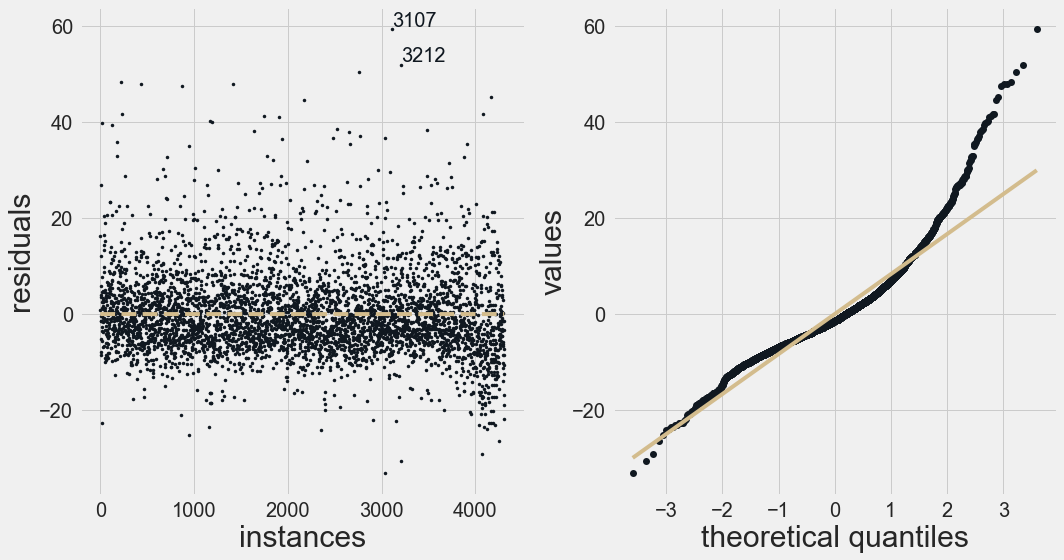

In [16]:
res_BIC_multiple = pd.read_csv('seminar_nfl/residuals_model_BIC_stepwise_full_multiple.csv', header = 0, index_col = 0)

# check of assumptions 
x1 = 3 #rows subplot
x2 = 30 # fontsize label 
x3 = 20 # fontsize ticks 
x4 = 30 #fontsize title 

error = res_BIC_multiple['x']
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
plt.plot(error, '.',markersize=7, color = black)
plt.plot(np.zeros(4309), '--', color = gold)
plt.xlabel('instances', fontsize = x2)
plt.ylabel('residuals', fontsize = x2)
plt.text(x = 3107,y = 60, s = '3107', size = 20, color = black)
plt.text(x = 3212,y = 52.5, s = '3212', size = 20, color = black)
plt.xticks(fontsize = x3)
plt.yticks(fontsize = x3)

ax = plt.subplot(1,2,2)
plt.style.use('fivethirtyeight')
stats.probplot(error, plot = plt)
ax.get_lines()[0].set_color(black)
ax.get_lines()[1].set_color(gold)
plt.xlabel('theoretical quantiles',fontsize = x2)
plt.ylabel('values',fontsize = x2)
plt.xticks(fontsize = x3) 
plt.yticks(fontsize = x3)
plt.title('')
plt.tight_layout()
plt.savefig('figures/residuals_final_chapter_BIC_full.png')

In [17]:
res_BIC_multiple.iloc[1942]

x   -2.324996
Name: 1943, dtype: float64

In [18]:
count = 0

for i in res_BIC_multiple['x']:
    if abs(i) > 20:
        count += 1
print(count)

162


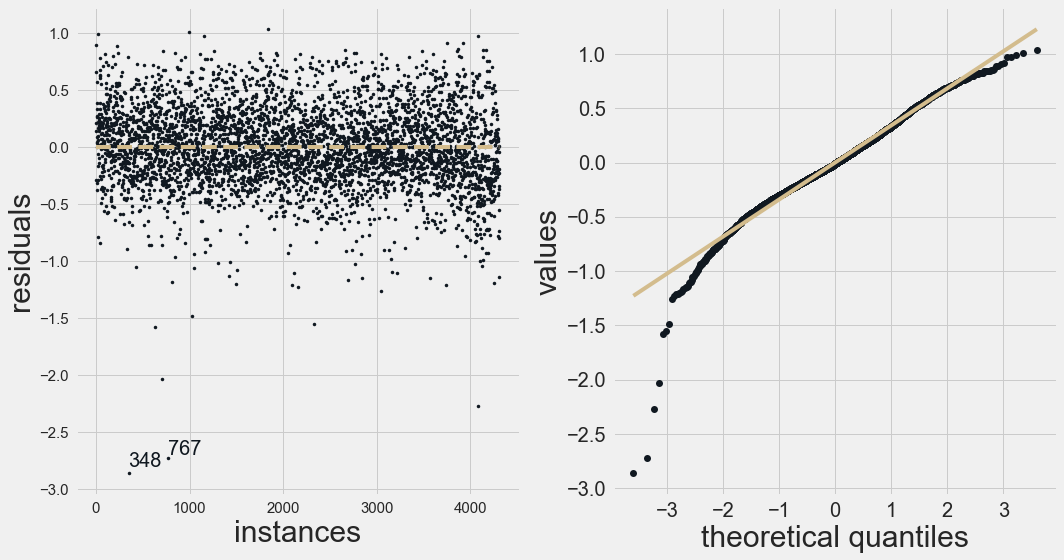

In [19]:
res_BIC_multiple_transformed = pd.read_csv('seminar_nfl/residuals_model_BIC_stepwise_full_multiple_transformed.csv', header = 0, index_col = 0)

# check of assumptions 
x1 = 3 #rows subplot
x2 = 30 # fontsize label 
x3 = 20 # fontsize ticks 
x4 = 30 #fontsize title 

error = res_BIC_multiple_transformed['x']
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
plt.plot(error, '.',markersize=7, color = black)
plt.plot(np.zeros(4309), '--', color = gold)
plt.xlabel('instances', fontsize = x2)
plt.ylabel('residuals', fontsize = x2)
plt.text(x = 348, y = -2.8, s = '348', size = 20, color = black)
plt.text(x = 767, y = -2.7, s = '767', size = 20, color = black)

ax = plt.subplot(1,2,2)
plt.style.use('fivethirtyeight')
stats.probplot(error, plot = plt)
ax.get_lines()[0].set_color(black)
ax.get_lines()[1].set_color(gold)
plt.xlabel('theoretical quantiles',fontsize = x2)
plt.ylabel('values',fontsize = x2)
plt.xticks(fontsize = x3) 
plt.yticks(fontsize = x3)
plt.title('')
plt.tight_layout()
plt.savefig('figures/residuals_final_chapter_BIC_full_transformed.png')

In [20]:
np.argsort(res_BIC_multiple_transformed['x'])

1        347
2        766
3       4074
4        708
5        634
6       2327
7       1029
8       3038
9       2153
10      3734
11      2093
12      1492
13      4255
14       814
15      2688
16      2840
17      3568
18      4299
19      1422
20      2110
21      3210
22      3157
23      1502
24      1046
25       425
26      4122
27      2765
28      1298
29      1430
30      4096
        ... 
4280    3879
4281    1933
4282    1105
4283    3040
4284      99
4285    3595
4286    2174
4287    2773
4288    1749
4289     229
4290    2757
4291    1919
4292     847
4293    1255
4294    3850
4295     710
4296    3484
4297    4161
4298    2662
4299    4128
4300    3866
4301     224
4302       4
4303    3915
4304    3752
4305    1149
4306    4082
4307      20
4308     994
4309    1840
Name: x, Length: 4309, dtype: int64

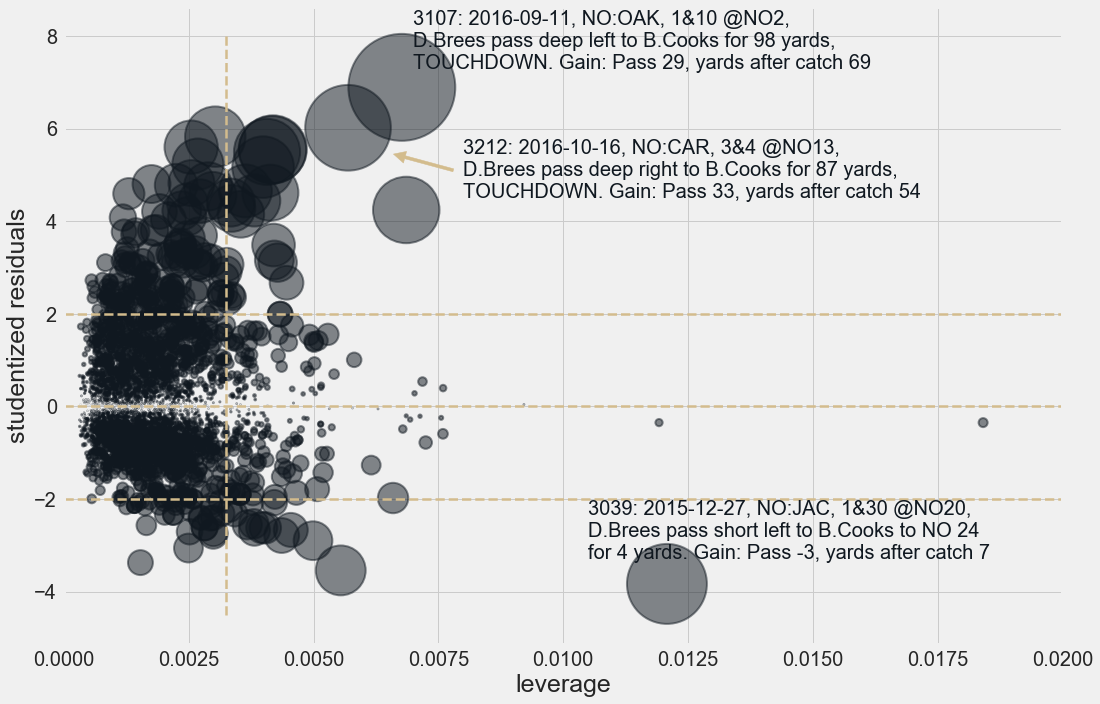

In [21]:
cooks = pd.read_csv('seminar_nfl/final_multiple_rec_cooks_BIC.csv', index_col = 0)
sresid = pd.read_csv('seminar_nfl/final_multiple_rec_sresid_BIC.csv', index_col = 0)
hat = pd.read_csv('seminar_nfl/final_mulitple_rec_hat_BIC.csv', index_col = 0)

plt.figure(figsize = (15.5,10))
plt.scatter(x = np.array(hat['x'].values), y = np.array(sresid['x'].values), s = np.array(cooks['x'].values)*250000, alpha = 0.5, linewidth = 2, c = black)
ax = plt.gca()
ax.set_xlim([0,0.020])

#add horizontal oriantation lines 
plt.plot(np.linspace(0,0.020, 50), [-2 for i in range(50)], alpha = 1, color = gold, linewidth = 2.5, linestyle = '--')
plt.plot(np.linspace(0,0.020, 50), [0 for i in range(50)], alpha = 1, color = gold, linewidth = 2.5, linestyle = '--')
plt.plot(np.linspace(0,0.020, 50), [2 for i in range(50)], alpha = 1, color = gold, linewidth = 2.5, linestyle = '--')

#add vertival lines
plt.plot([2*(6+1)/len(np.array(hat['x'].values)) for i in range(50)], np.linspace(-4.5, 8, 50), alpha = 1, color = gold, linewidth = 2.5, linestyle = '--')

# add index of instances for potential outliers
x1 = 20 #Text size in the plot
x2 = 25 #size of labels 
x3 = 20 #size of ticks
x4 = black #color of text 

plt.text(x = 0.0105, y = -3.3, s = '3039: 2015-12-27, NO:JAC, 1&30 @NO20, \nD.Brees pass short left to B.Cooks to NO 24 \nfor 4 yards. Gain: Pass -3, yards after catch 7 ', size = x1, color = x4)
#plt.text(x= 0.0173, y = -0.4, s = '1942', size = x1, color = x4)
plt.text(x= 0.007, y = 7.3, s = '3107: 2016-09-11, NO:OAK, 1&10 @NO2,\nD.Brees pass deep left to B.Cooks for 98 yards, \nTOUCHDOWN. Gain: Pass 29, yards after catch 69', size = x1, color = x4)
plt.text(x = 0.008, y = 4.5, s = '3212: 2016-10-16, NO:CAR, 3&4 @NO13, \nD.Brees pass deep right to B.Cooks for 87 yards, \nTOUCHDOWN. Gain: Pass 33, yards after catch 54  ', size= x1, color = x4)  
#plt.arrow(x= 0.01, y = 8, dx = -0.003, dy = -1, width = 0.0005, length_includes_head=True,head_width=0.08, head_length=0.002)
plt.annotate("", xytext=(0.0078,5.1), xy=(0.0066, 5.45), arrowprops={'width':3, 'color': gold})

plt.xlabel('leverage', size = x2)
plt.ylabel('studentized residuals', size = x2)
plt.xticks(size = x3)
plt.yticks(size = x3)

rec = matplotlib.patches.Rectangle(xy= (0.0003,2), width = 0.005, height = 4.4, fill = False, linewidth = 2, edgecolor = 'r')
#ax.add_patch(rec)

plt.tight_layout()
plt.savefig('figures/influenceplot_multiple_rec_BIC.png')
plt.show()

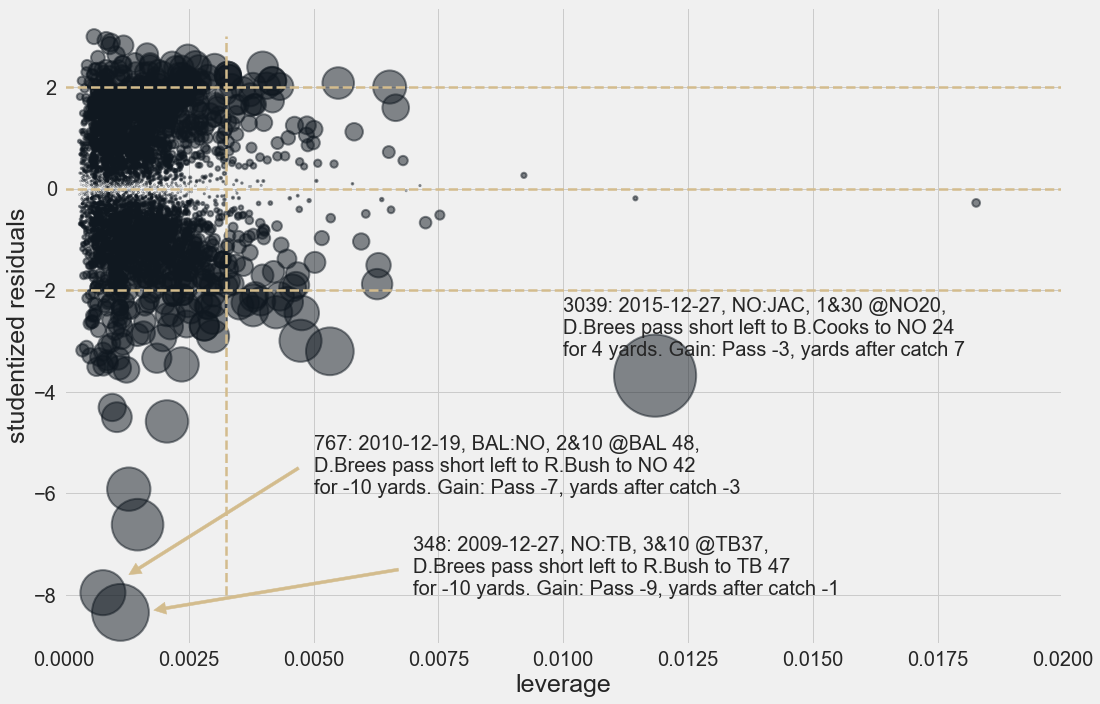

In [22]:
cooks = pd.read_csv('seminar_nfl/final_multiple_rec_cooks_BIC_transformed.csv', index_col = 0)
sresid = pd.read_csv('seminar_nfl/final_multiple_rec_sresid_BIC_transformed.csv', index_col = 0)
hat = pd.read_csv('seminar_nfl/final_mulitple_rec_hat_BIC_transformed.csv', index_col = 0)

plt.figure(figsize = (15.5,10))
plt.scatter(x = np.array(hat['x'].values), y = np.array(sresid['x'].values), s = np.array(cooks['x'].values)*250000, alpha = 0.5, linewidth = 2, c = black)
ax = plt.gca()
ax.set_xlim([0,0.020])

#add horizontal oriantation lines 
plt.plot(np.linspace(0,0.020, 50), [-2 for i in range(50)], alpha = 1, color = gold, linewidth = 2.5, linestyle = '--')
plt.plot(np.linspace(0,0.020, 50), [0 for i in range(50)], alpha = 1, color = gold, linewidth = 2.5, linestyle = '--')
plt.plot(np.linspace(0,0.020, 50), [2 for i in range(50)], alpha = 1, color = gold, linewidth = 2.5, linestyle = '--')

# add index of instances for potential outliers
x1 = 20 #Text size in the plot
x2 = 25 #size of labels 
x3 = 20 #size of ticks
x4 = black #color of text

#add vertival lines
plt.plot([2*(6+1)/len(np.array(hat['x'].values)) for i in range(50)], np.linspace(-8, 3, 50), alpha = 1, color = gold, linewidth = 2.5, linestyle = '--')
plt.text(x = 0.010, y = -3.3, s = '3039: 2015-12-27, NO:JAC, 1&30 @NO20, \nD.Brees pass short left to B.Cooks to NO 24 \nfor 4 yards. Gain: Pass -3, yards after catch 7', size = x1)
#plt.text(x= 0.017, y = -0.4, s = '1942', size = x1)
plt.text(x= 0.007, y = -8, s = '348: 2009-12-27, NO:TB, 3&10 @TB37, \nD.Brees pass short left to R.Bush to TB 47 \nfor -10 yards. Gain: Pass -9, yards after catch -1', size = x1)
plt.text(x = 0.005, y = -6, s = '767: 2010-12-19, BAL:NO, 2&10 @BAL 48, \nD.Brees pass short left to R.Bush to NO 42 \nfor -10 yards. Gain: Pass -7, yards after catch -3', size = x1)

plt.annotate("", xytext=(0.0067,-7.5), xy=(0.0018, -8.3), arrowprops={'width':3, 'color': gold})
plt.annotate("", xytext=(0.0047,-5.5), xy=(0.0013, -7.6), arrowprops={'width':3, 'color': gold})

plt.xlabel('leverage', size = x2)
plt.ylabel('studentized residuals', size = x2)
plt.xticks(size = x3)
plt.yticks(size = x3)

plt.tight_layout()
plt.savefig('figures/influenceplot_multiple_rec_BIC_transformed.png')
plt.show()

In [23]:
pd.concat([df_complete_pass.iloc[3106], df_complete_pass.iloc[3211], df_complete_pass.iloc[3038], df_complete_pass.iloc[1941], df_complete_pass.iloc[347], df_complete_pass.iloc[766]],axis = 1)

,4491,4648,4397,2819,495,1093
game_id,2016091105,2016101605,2015122700,2013110303,2009122707,2010121909
game_date,2016-09-11 00:00:00,2016-10-16 00:00:00,2015-12-27 00:00:00,2013-11-03 00:00:00,2009-12-27 00:00:00,2010-12-19 00:00:00
yardline_100,98,87,80,50,37,48
quarter_seconds_remaining,483,163,103,151,196,439
half_seconds_remaining,1383,1063,1003,1051,1096,439
game_seconds_remaining,1383,2863,2803,1051,1096,439
down,1,3,1,3,3,2
qtr,3,1,1,3,3,4
ydstogo,10,4,30,38,10,10
ydsnet,98,93,98,34,33,13


In [24]:
df1 = data
df1 = df1.loc[(df1['play_type'] == 'pass')]
df1 = df1.loc[(df1['posteam'] == 'NO')]
df1 = df1.drop(df1[df1.complete_pass == 0].index)

df1 = df1.reset_index()

print(df1.iloc[767].air_yards)

-7.0


In [25]:
def eval_yds_100_ydsnet(start):
    yds = np.array(range(0,110-start,10))
    yds_int = np.array(range(100-start, -10,-10))

    yds_100 = yds_int*0.24
    yds_net = yds *0.276
    x = yds_100 + yds_net
    return(yds_100, yds_net, x, yds, yds_int)

yds_100, yds_net, x, yds, yds_int = eval_yds_100_ydsnet(40) 
print(yds_100)
print(yds_net)
print(x)


[14.4 12.   9.6  7.2  4.8  2.4  0. ]
[ 0.    2.76  5.52  8.28 11.04 13.8  16.56]
[14.4  14.76 15.12 15.48 15.84 16.2  16.56]


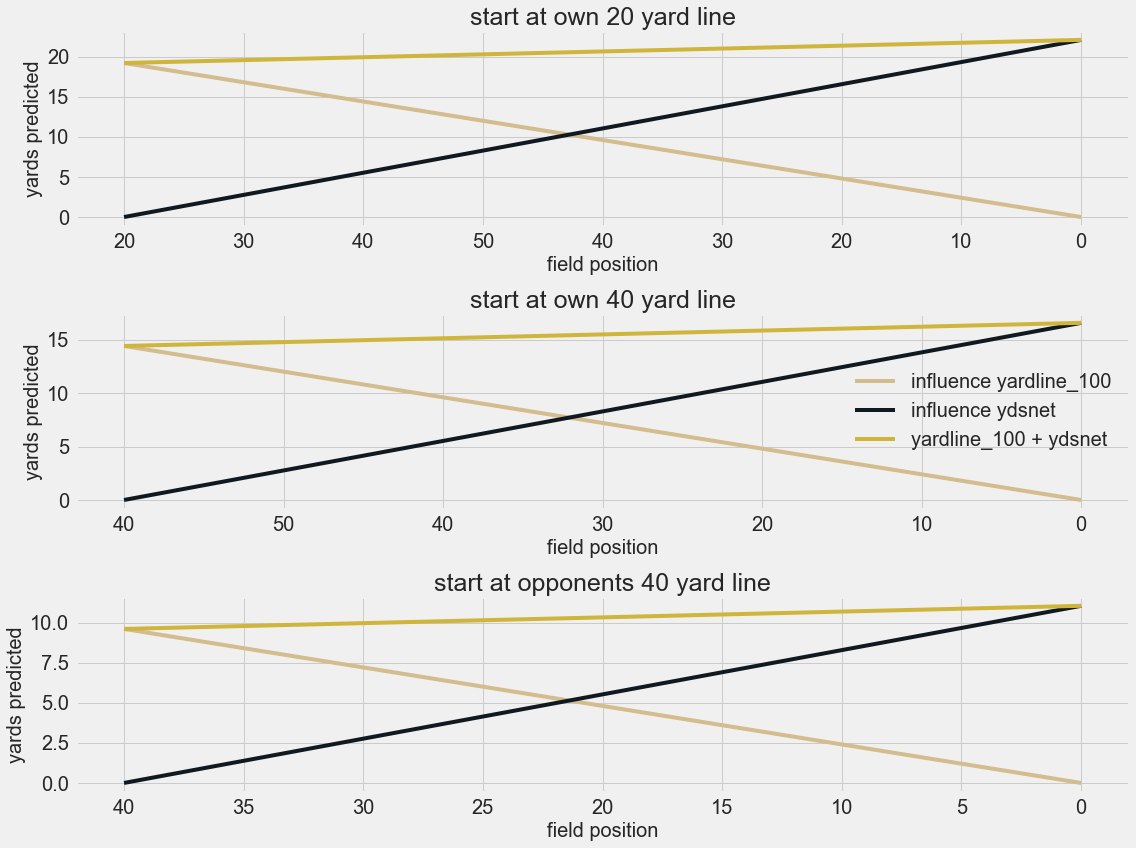

In [26]:
x1 = 20 # size xticks
x2 = 25 # headline 
x3 = 20 # size x label 

yds_100, yds_net, x, yds, yds_int = eval_yds_100_ydsnet(20) 

plt.figure(figsize = (16,12))
plt.subplot(3,1,1)
plt.title('start at own 20 yard line', size = x2)
plt.plot(yds, yds_100, label = 'influence yardline_100', color = gold)
plt.plot(yds, yds_net, label = 'influence ydsnet', color = black)
plt.plot(yds, x, label = 'yardline_100 + ydsnet', color = '#cfb53b')

plt.xlabel('field position', size = x3)
plt.ylabel('yards predicted', size = x3)
plt.xticks(np.arange(0,90,10), [20,30,40,50,40,30,20,10,0],size = x1)
plt.yticks(size = x1)

#plt.legend()

yds_100, yds_net, x, yds, yds_int = eval_yds_100_ydsnet(40) 

plt.subplot(3,1,2)
plt.title('start at own 40 yard line', size = x2)
plt.plot(yds, yds_100, label = 'influence yardline_100', color = gold)
plt.plot(yds, yds_net, label = 'influence ydsnet', color = black)
plt.plot(yds, x, label = 'yardline_100 + ydsnet', color = '#cfb53b')

plt.xlabel('field position', size = x3)
plt.ylabel('yards predicted', size = x3)
plt.xticks(np.arange(0,70,10), [40, 50, 40,30,20,10,0],size = x1)
plt.yticks(size = x1)

plt.legend(fontsize = x3)

yds_100, yds_net, x, yds, yds_int = eval_yds_100_ydsnet(60)

plt.subplot(3,1,3)
plt.title('start at opponents 40 yard line', size = x2)
plt.plot(yds, yds_100, label = 'influence yardline_100', color = gold)
plt.plot(yds, yds_net, label = 'influence ydsnet', color = black)
plt.plot(yds, x, label = 'yardline_100 + ydsnet', color = '#cfb53b')

plt.xlabel('field position', size = x3)
plt.ylabel('yards predicted', size = x3)
plt.xticks(np.arange(0, 45,5), np.arange(40,-5,-5), size = x1)
plt.yticks(size = x1)

#plt.legend()

plt.tight_layout()
plt.savefig('figures/influence_yardline_100_and_ydsnet_on_BIC_model.png')
plt.show()

In [27]:
(-3.427*10**-4) *3600

-1.2337200000000001

In [28]:
from sklearn import svm

reg = svm.SVC()
reg.fit(df_train.drop(['complete_pass'], axis = 1).values,df_train[['complete_pass']].values) 

/Users/felixbok/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'unknown'